# Impotrs

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load & Preprocess

In [68]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
cols = ['age','workclass','fnlwgt','education','edu-num','marital','occupation',
        'relationship','race','sex','capital-gain','capital-loss','hours','country','income']

data = pd.read_csv(url, names=cols)
cat_features = ['workclass', 'education', 'marital', 'occupation', 
                'relationship', 'race', 'sex', 'country']

X = data[cat_features]
y = data['income']

print(f"X: {X.shape}, Classes: {np.unique(y)}")

X: (32561, 8), Classes: [' <=50K' ' >50K']


# Data Split

In [70]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
# Convert to NumPy arrays (ensure indexing works)
X_train = np.array(X_train)
X_val   = np.array(X_val)
X_test  = np.array(X_test)

Train: (22792, 8), Val: (4884, 8), Test: (4885, 8)


# Categorical Naive Bayes

In [72]:
class CategoricalNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.feature_encoders = []
        self.classes_ = None
        
    def fit(self, X, y):
        # Encode target labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        n_classes = len(self.classes_)
        
        # Encode each feature separately (integer 0→N-1)
        X_enc = np.zeros_like(X)
        self.feature_encoders = []
        
        for feat in range(X.shape[1]):
            enc = LabelEncoder()
            X_enc[:, feat] = enc.fit_transform(X[:, feat])
            self.feature_encoders.append(enc)

        # Class priors
        class_counts = np.bincount(y_encoded)
        total = len(y_encoded)
        self.class_log_prior_ = np.log((class_counts + self.alpha) / (total + self.alpha * n_classes))
        
        # Likelihood
        self.feature_log_prob_ = []
        
        for feat in range(X_enc.shape[1]):
            feat_probs = {}
            vocab_size = len(np.unique(X_enc[:, feat]))
            
            for cls in range(n_classes):
                cls_samples = X_enc[y_encoded == cls, feat]
                values, counts = np.unique(cls_samples, return_counts=True)

                probs = np.full(vocab_size, np.log(self.alpha / (len(cls_samples) + self.alpha * vocab_size)))
                
                for v, c in zip(values, counts):
                    probs[int(v)] = np.log((c + self.alpha) / (len(cls_samples) + self.alpha * vocab_size))

                feat_probs[cls] = probs
            self.feature_log_prob_.append(feat_probs)

    def predict(self, X):
        # Apply same encoding used in training
        X_enc = np.zeros_like(X)
        for feat in range(X.shape[1]):
            X_enc[:, feat] = self.feature_encoders[feat].transform(X[:, feat])

        n_samples = X_enc.shape[0]
        log_prob = np.zeros((n_samples, len(self.classes_)))
        
        for i, x in enumerate(X_enc):
            for c in range(len(self.classes_)):
                score = self.class_log_prior_[c]
                for feat_idx, feat_val in enumerate(x):
                    probs = self.feature_log_prob_[feat_idx][c]
                    score += probs[int(feat_val)]
                log_prob[i, c] = score
        
        return self.label_encoder.inverse_transform(np.argmax(log_prob, axis=1))


# Hyperparameter Tuning

α=0.1: 0.7930
α=0.5: 0.7928
α=1.0: 0.7926
α=2.0: 0.7920
α=3.0: 0.7922
α=5.0: 0.7930

Best α: 0.1


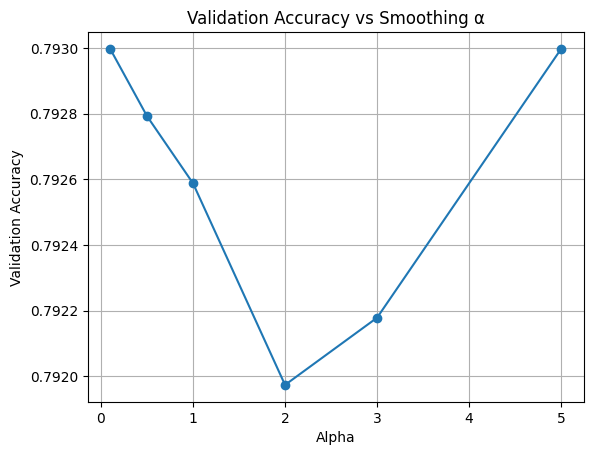

In [74]:
alphas = [0.1, 0.5, 1.0, 2.0, 3.0, 5.0]
val_scores = []

for alpha in alphas:
    model = CategoricalNB(alpha=alpha)
    model.fit(X_train, y_train)
    score = accuracy_score(y_val, model.predict(X_val))
    val_scores.append(score)
    print(f"α={alpha}: {score:.4f}")

best_alpha = alphas[np.argmax(val_scores)]
print(f"\nBest α: {best_alpha}")

# Plot
plt.figure()
plt.plot(alphas, val_scores, marker='o')
plt.title("Validation Accuracy vs Smoothing α")
plt.xlabel("Alpha")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


# Final Model & Results

In [76]:
# Train on train+val
X_train_final = np.vstack([X_train, X_val])
y_train_final = np.hstack([y_train, y_val])

final_model = CategoricalNB(alpha=best_alpha)
final_model.fit(X_train_final, y_train_final)

# Test results
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nFINAL TEST RESULTS:")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


FINAL TEST RESULTS:
Accuracy: 0.7969

Confusion Matrix:
 [[3077  678]
 [ 314  816]]

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.82      0.86      3755
        >50K       0.55      0.72      0.62      1130

    accuracy                           0.80      4885
   macro avg       0.73      0.77      0.74      4885
weighted avg       0.82      0.80      0.81      4885



# Analysis Feature Selection

Features ['workclass', 'education', 'marital']: Accuracy = 0.8184
Features ['occupation', 'relationship', 'race', 'sex', 'country']: Accuracy = 0.7920
Features ['workclass', 'education', 'marital', 'occupation', 'relationship', 'race', 'sex', 'country']: Accuracy = 0.7930


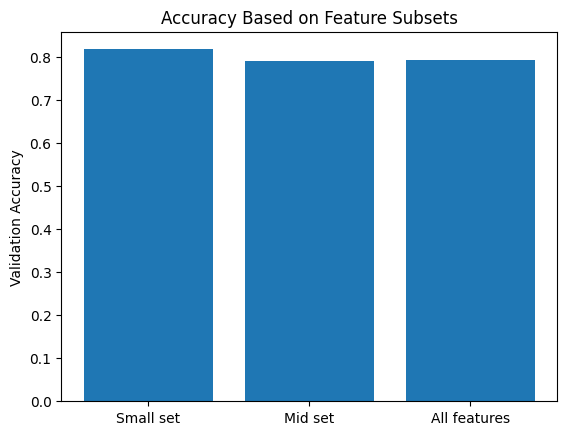

In [78]:
feature_sets = [
    ['workclass', 'education', 'marital'],  # small group of features
    ['occupation', 'relationship', 'race', 'sex', 'country'],  # large group of features
    cat_features  # all features
]

feature_scores = []


for features in feature_sets:
    X_train_subset = X_train[:, [cat_features.index(f) for f in features]]
    X_val_subset = X_val[:, [cat_features.index(f) for f in features]]
    
    model = CategoricalNB(alpha=best_alpha)
    model.fit(X_train_subset, y_train)
    score = accuracy_score(y_val, model.predict(X_val_subset))
    feature_scores.append(score)
    print(f"Features {features}: Accuracy = {score:.4f}")

#Plot
groups = ["Small set", "Mid set", "All features"]

plt.figure()
plt.bar(groups, feature_scores)
plt.title("Accuracy Based on Feature Subsets")
plt.ylabel("Validation Accuracy")
plt.show()


#  Performance Comparison: Compare with sklearn's MultinomialNB

In [80]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Encode categorical features 
X_train_enc = np.column_stack([LabelEncoder().fit_transform(X_train[:, i]) for i in range(X_train.shape[1])])
X_val_enc   = np.column_stack([LabelEncoder().fit_transform(X_val[:, i]) for i in range(X_val.shape[1])])
X_test_enc  = np.column_stack([LabelEncoder().fit_transform(X_test[:, i]) for i in range(X_test.shape[1])])

# Encode target labels
le_y = LabelEncoder()
y_train_enc = le_y.fit_transform(y_train)
y_val_enc   = le_y.transform(y_val)   
y_test_enc  = le_y.transform(y_test)   

# Train MultinomialNB on train + val
X_train_final = np.vstack([X_train_enc, X_val_enc])
y_train_final = np.hstack([y_train_enc, y_val_enc])

sk_model = MultinomialNB(alpha=best_alpha)
sk_model.fit(X_train_final, y_train_final)

# Test
y_pred = sk_model.predict(X_test_enc)
accuracy = accuracy_score(y_test_enc, y_pred)

print(f"MultinomialNB Test Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred))


MultinomialNB Test Accuracy: 0.7548

Confusion Matrix:
 [[3221  534]
 [ 664  466]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      3755
           1       0.47      0.41      0.44      1130

    accuracy                           0.75      4885
   macro avg       0.65      0.64      0.64      4885
weighted avg       0.75      0.75      0.75      4885

